In [388]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

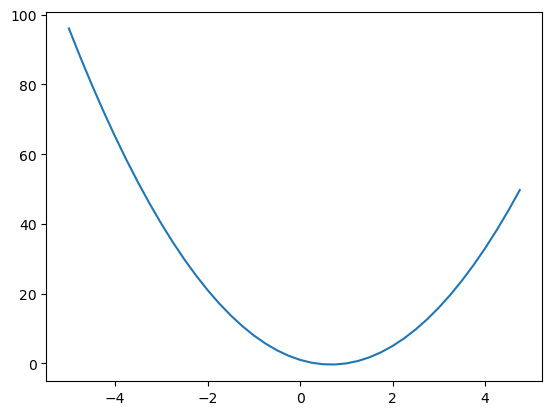

In [2]:

def f(x):
    return 3 * x**2 - 4 * x + 1

xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [3]:
x = 3
y1 = f(x)
h = 0.0001
y2 = f(x + h)
(y2 - y1) / h

14.000300000063248

In [4]:
# Derivative of a function w.r.t different variables 
# Numerical approximation with small offset
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c 
a += h 
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('est slope', (d2 - d1) / h)

d1 4.0
d2 3.9999699999999994
est slope -3.000000000064062


In [372]:
# Value base class 

def tanh(x):
    return (math.exp(x * 2) - 1) / (math.exp(x * 2) + 1)

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # Represents derivative of final output w.r.t this variable
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data + other.data, (self, other), '+')
        # h = 0.00001
        def _backward():
            self.grad += 1.0 * ret.grad 
            other.grad += 1.0 * ret.grad 

            # self._backward()
            # other._backward()
        
        ret._backward = _backward
        # self.grad = 1.0 # ((self.data + h + other.data) - ret.data) / h 
        # other.grad = 1.0 #((self.data + h + other.data) - ret.data) / h 
        return ret 
    

    def __sub__(self, other):
        return self + (-other)
    
    
    def __neg__(self):
        return self * -1
    

    def __radd__(self, other): 
        return self + other
    
    
    def __rsub__(self, other):
        return self - other 
    

    def __rmul__(self, other): 
        return self * other

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * ret.grad 
            other.grad += self.data * ret.grad

        ret._backward = _backward 

        return ret 
    
    
    # Derivative of tanh function is (1 - tanh(x)**2)
    def tanh(self):
        
        ret = Value(tanh(self.data), (self,), 'tanh')
        # h = 0.00001
        # self.grad = (tanh(self.data + h) - ret.data) / h
        # self.grad = 1 - ret.data ** 2

        # self.backpropagate(self.grad)
        def _backward():
            self.grad += (1 - ret.data ** 2) * ret.grad 

            # self._backward()

        ret._backward = _backward

        return ret
    
    def backward(self):
        # Build dag from final node, call backward on each one. 
        dag = []
        visited = set()
        def build_dag(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_dag(child)
                dag.append(v)
        build_dag(self)

        self.grad = 1.0
        # Start at this node, then propagate to children. 
        for node in reversed(dag):
            node._backward()

    def exp(self):
        ret = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += ret.data * ret.grad 
        
        ret._backward = _backward 

        return ret 
    

    # Want division as b**-1
    # implement as x^-1
    def __truediv__(self, other): 
        return self * other**-1


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float pow"
        ret = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other) * (self.data ** (other - 1)) * ret.grad
        
        ret._backward = _backward 
        return ret 

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a * b; e.label = 'e'
# d = e + c ; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label = 'L'
# L

In [374]:
#Copy pasted
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [375]:
lr = 0.01

# Manual optimizer step
a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad


e = a * b
d = e + c
L = d * f 
L

Value(data=Value(data=Value(data=Value(data=-84.19837010303556))))

In [376]:
# Manual grad checker 
def grad_check():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d * f

    h = 0.0001
    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d * f
    print((L2.data - L1.data) / h)
grad_check()

6.000000000021544


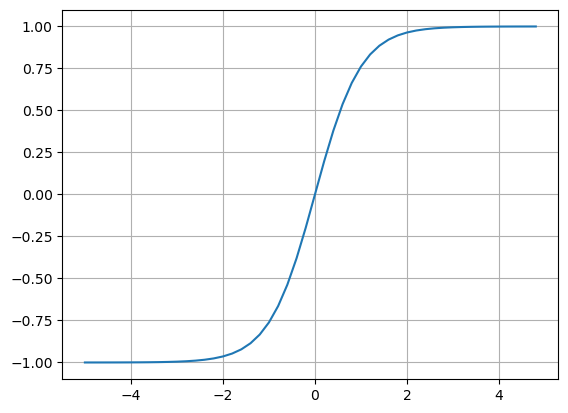

In [377]:
# Vis tanh function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [378]:
# Calculating the gradient for a simple neuron
# Inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias: b
b = Value(6.8813735870195432, label='b')

# Calculating
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# Output pre-activation function
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

# o._backward()


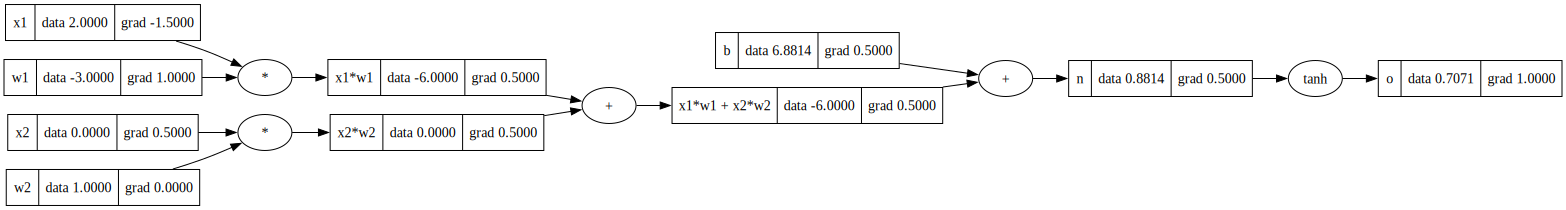

In [379]:
o.backward()
draw_dot(o)

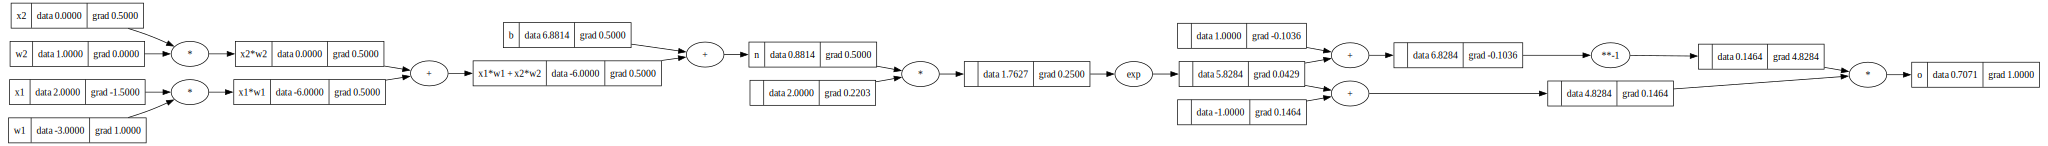

In [380]:
# Manual tanh
# Inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias: b
b = Value(6.8813735870195432, label='b')

# Calculating
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# Output pre-activation function
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
# e.backward()
# draw_dot(e)
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

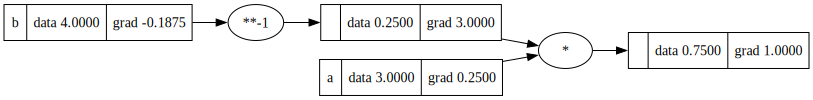

In [381]:

# Make sure that gradients accumulate if you use the same variable for multiple computations 
a = Value(3.0, label='a')
b = Value(4.0, label='b')
# b = a + a; b.label = 'b'
c = a / b
c.backward()
draw_dot(c)

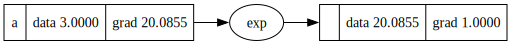

In [383]:
a = Value(3.0, label='a')
c = a.exp()
c.backward()
draw_dot(c)

In [384]:
import torch 

In [385]:
# Torch reimplementation
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True 
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True 
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True 
b = torch.Tensor([6.881373587095432]).double()      ; b.requires_grad = True
n = x1 *w1 + x2 * w2 + b 
o = torch.tanh(n) 

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [387]:
o.item()

0.7071066904050358

In [568]:

# Neuron class

class Neuron: 
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # forward function
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh() 
        return out 

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts 
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [569]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9448415036301485)

In [570]:
len(n.parameters())

41

In [571]:

# Example dataset 
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]

In [573]:
# Training 
nsteps = 30
lr = 0.1
for i in range(nsteps):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum([ (ygt - yp)**2 for ygt, yp in zip(ys, ypred)])

    # backward 
    # zero grad
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update 
    for p in n.parameters():
        p.data += - p.grad * lr
    
    print(i, loss.data)


print(loss)

0 0.011053939527619148
1 0.010599095616708566
2 0.010180918386933274
3 0.009795130540935051
4 0.009438095175676954
5 0.009106700335217658
6 0.008798267651794305
7 0.0085104794120014
8 0.00824131985632149
9 0.007989027575299443
10 0.007752056631173325
11 0.007529044595418187
12 0.007318786109003055
13 0.007120210883792461
14 0.00693236529889946
15 0.0067543969250947015
16 0.006585541448052708
17 0.006425111567734622
18 0.006272487534206727
19 0.006127109045304238
20 0.00598846828295538
21 0.005856103905810088
22 0.005729595848435281
23 0.0056085608035391105
24 0.005492648284839731
25 0.005381537185362124
26 0.005274932759940312
27 0.005172563972166163
28 0.005074181155453746
29 0.004979553945676841
Value(data=0.004979553945676841)
